# Optimizer Example
Jena Climate RNN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 26-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('fivethirtyeight')

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|RNN|Modern|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 1.95 s
Wall time: 2.25 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 133.6834 - mean_absolute_error: 9.5290 - val_loss: 74.5832 - val_mean_absolute_error: 6.8718
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - loss: 52.5463 - mean_absolute_error: 5.7500 - val_loss: 44.8783 - val_mean_absolute_error: 5.1672
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - loss: 32.2554 - mean_absolute_error: 4.3957 - val_loss: 31.6848 - val_mean_absolute_error: 4.2469
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 25.2157 - mean_absolute_error: 3.8906 - val_loss: 26.1230 - val_mean_absolute_error: 3.8619
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 21.8546 - mean_absolute_error: 3.6258 - val_loss: 23.0723 - val_mean_absolute_error: 3.6204
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - loss: 19.8217 - mean_absolute_error: 3.4575 - val_loss: 21.1296 - val_mean_absolute_error: 3.4853
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - loss: 18.2972 - me

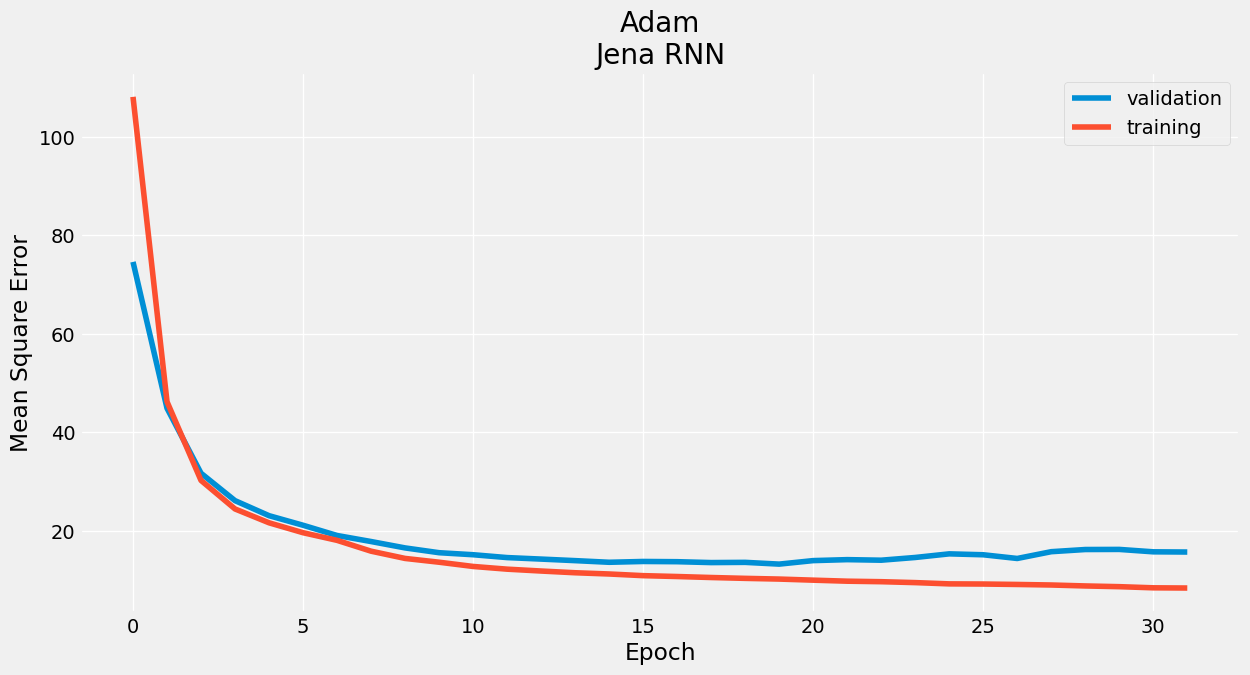

In [28]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h0.history['loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

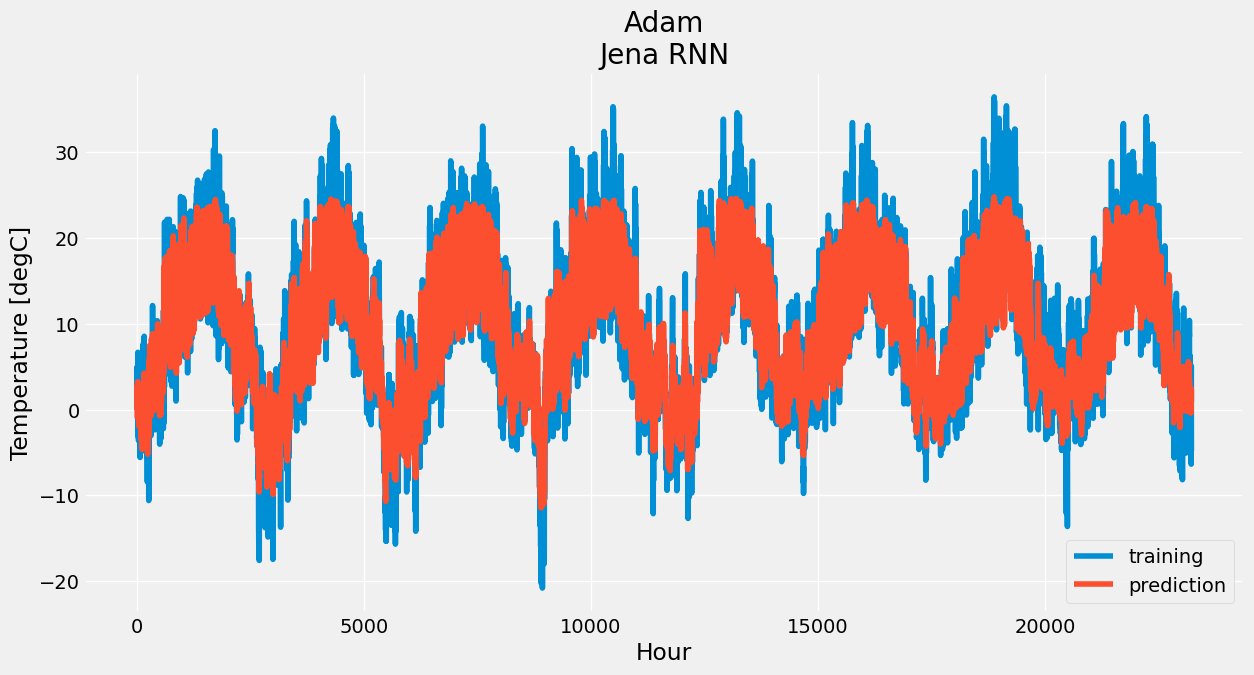

In [29]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(y_train)
plt.plot(p0.flatten())
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

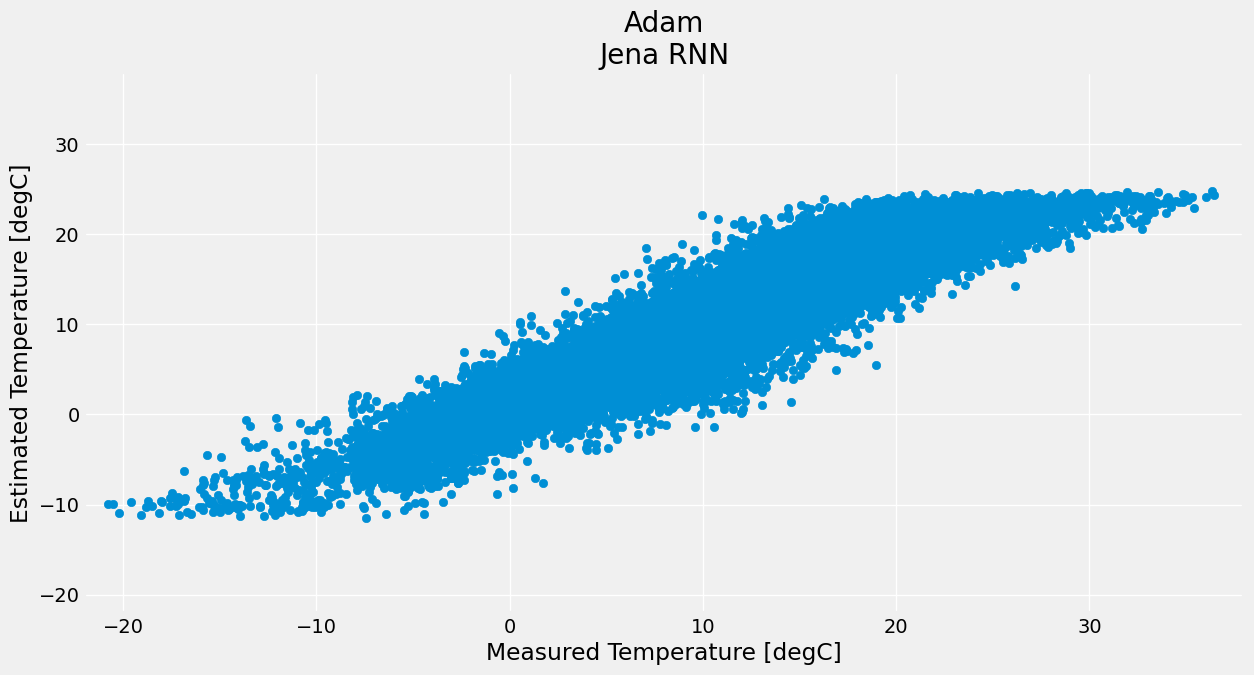

In [30]:
plt.figure(figsize=(13.33, 6.67))
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, Adam with Weight Decay

In [16]:
%%time
h1,p1=model_build('adamw')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 128.0979 - mean_absolute_error: 9.3415 - val_loss: 72.4392 - val_mean_absolute_error: 6.8739
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 936ms/step - loss: 44.7377 - mean_absolute_error: 5.2513 - val_loss: 38.7724 - val_mean_absolute_error: 4.8170
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 862ms/step - loss: 28.1073 - mean_absolute_error: 4.1034 - val_loss: 29.2884 - val_mean_absolute_error: 4.1260
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 921ms/step - loss: 23.2824 - mean_absolute_error: 3.7183 - val_loss: 25.0458 - val_mean_absolute_error: 3.8001
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 903ms/step - loss: 20.8456 - mean_absolute_error: 3.5304 - val_loss: 21.9067 - val_mean_absolute_error: 3.5343
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 966ms/step - loss: 18.7492 - mean_absolute_error: 3.3536 - val_loss: 20.1934 - val_mean_absolute_error: 3.3803
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 940ms/step - loss: 17.4684 

### Third Model, AdaFactor

In [17]:
%%time
h2,p2=model_build('adafactor')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 151.8484 - mean_absolute_error: 10.2081 - val_loss: 184.1016 - val_mean_absolute_error: 11.3778
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 896ms/step - loss: 144.9466 - mean_absolute_error: 9.9604 - val_loss: 175.5181 - val_mean_absolute_error: 11.0927
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 878ms/step - loss: 136.6348 - mean_absolute_error: 9.6573 - val_loss: 164.9068 - val_mean_absolute_error: 10.7251
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 908ms/step - loss: 125.9736 - mean_absolute_error: 9.2425 - val_loss: 151.2221 - val_mean_absolute_error: 10.2240
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 902ms/step - loss: 112.6235 - mean_absolute_error: 8.6889 - val_loss: 133.3582 - val_mean_absolute_error: 9.5162
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 911ms/step - loss: 96.6845 - mean_absolute_error: 7.9639 - val_loss: 112.4665 - val_mean_absolute_error: 8.6031
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 945ms/step -

### 4th Model, LION

In [18]:
%%time
h3,p3=model_build('lion')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 899ms/step - loss: 133.6636 - mean_absolute_error: 9.5383 - val_loss: 83.3453 - val_mean_absolute_error: 7.4972
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 790ms/step - loss: 55.9721 - mean_absolute_error: 5.9678 - val_loss: 54.7434 - val_mean_absolute_error: 6.0192
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 919ms/step - loss: 54.0872 - mean_absolute_error: 5.8269 - val_loss: 54.9236 - val_mean_absolute_error: 6.0380
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 934ms/step - loss: 49.5075 - mean_absolute_error: 5.5818 - val_loss: 54.3948 - val_mean_absolute_error: 5.9454
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 707ms/step - loss: 47.1410 - mean_absolute_error: 5.4343 - val_loss: 49.9023 - val_mean_absolute_error: 5.6519
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 48s 934ms/step - loss: 44.7948 - mean_absolute_error: 5.2628 - val_loss: 46.2386 - val_mean_absolute_error: 5.4083
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 910ms/step - loss: 39.82

### 5th Model, Adam with Nesterov Momentum

In [19]:
%%time
h4,p4=model_build('nadam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 829ms/step - loss: 140.6186 - mean_absolute_error: 9.7626 - val_loss: 71.9475 - val_mean_absolute_error: 6.7469
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 730ms/step - loss: 46.3887 - mean_absolute_error: 5.2908 - val_loss: 42.8062 - val_mean_absolute_error: 5.0604
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 825ms/step - loss: 30.3800 - mean_absolute_error: 4.2536 - val_loss: 31.3718 - val_mean_absolute_error: 4.2350
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 875ms/step - loss: 25.1161 - mean_absolute_error: 3.8792 - val_loss: 25.9559 - val_mean_absolute_error: 3.8605
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 838ms/step - loss: 21.4765 - mean_absolute_error: 3.5825 - val_loss: 23.4939 - val_mean_absolute_error: 3.6749
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 838ms/step - loss: 19.3186 - mean_absolute_error: 3.4000 - val_loss: 20.5874 - val_mean_absolute_error: 3.4429
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - loss: 17.36

### 6th Model, Follow the Regularized Leader

In [20]:
%%time
h5,p5=model_build('ftrl')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 654ms/step - loss: 153.8278 - mean_absolute_error: 10.2761 - val_loss: 189.4350 - val_mean_absolute_error: 11.5627
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 616ms/step - loss: 150.4953 - mean_absolute_error: 10.1688 - val_loss: 186.5871 - val_mean_absolute_error: 11.4942
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 478ms/step - loss: 147.4799 - mean_absolute_error: 10.0745 - val_loss: 182.9531 - val_mean_absolute_error: 11.4044
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 578ms/step - loss: 143.1839 - mean_absolute_error: 9.9390 - val_loss: 176.3352 - val_mean_absolute_error: 11.2308
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - loss: 134.1662 - mean_absolute_error: 9.6406 - val_loss: 152.7166 - val_mean_absolute_error: 10.5109
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 607ms/step - loss: 102.8433 - mean_absolute_error: 8.3801 - val_loss: 102.5206 - val_mean_absolute_error: 8.3761
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 610ms

### 7th Model, AdaMax

In [21]:
%%time
h6,p6=model_build('adamax')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - loss: 140.6901 - mean_absolute_error: 9.8274 - val_loss: 109.5291 - val_mean_absolute_error: 8.6028
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 70.4605 - mean_absolute_error: 6.6890 - val_loss: 63.6752 - val_mean_absolute_error: 6.3929
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 43.2079 - mean_absolute_error: 5.1556 - val_loss: 43.4530 - val_mean_absolute_error: 5.1181
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 31.8252 - mean_absolute_error: 4.3620 - val_loss: 33.5006 - val_mean_absolute_error: 4.3820
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 26.4514 - mean_absolute_error: 3.9579 - val_loss: 29.6339 - val_mean_absolute_error: 4.1099
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 24.1129 - mean_absolute_error: 3.7991 - val_loss: 26.9223 - val_mean_absolute_error: 3.9345
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 22.8136 - 

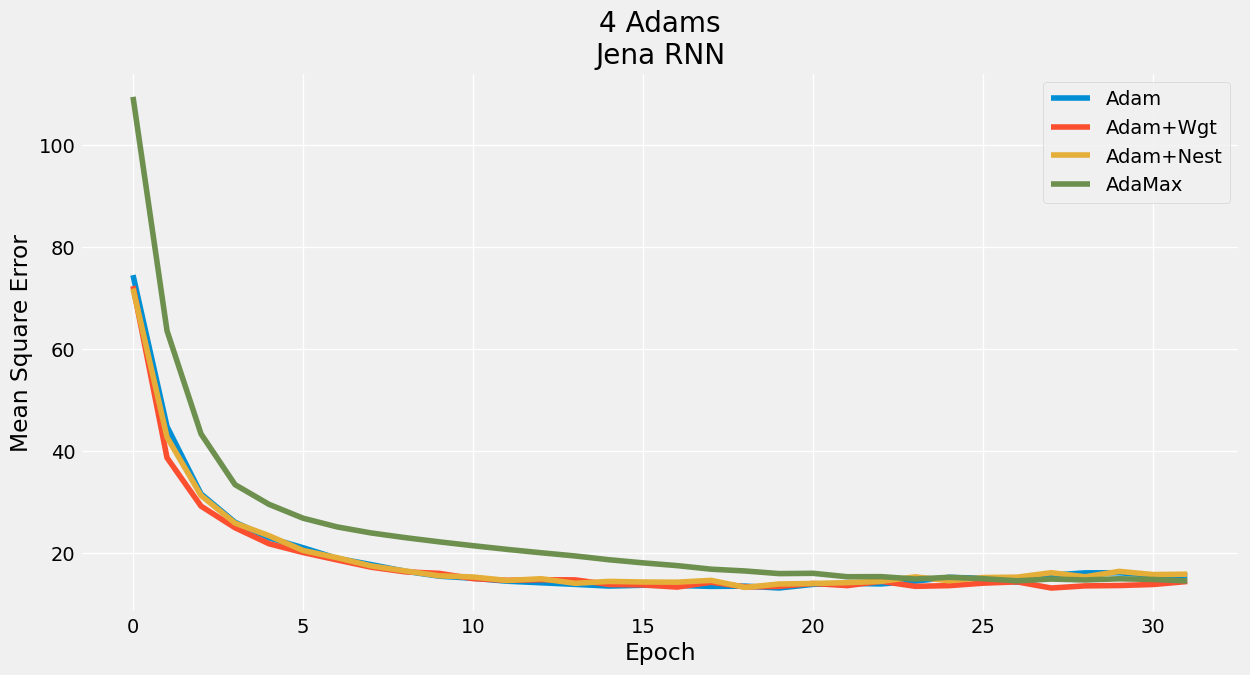

In [22]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams\nJena RNN')
plt.grid(color='white')
plt.show()

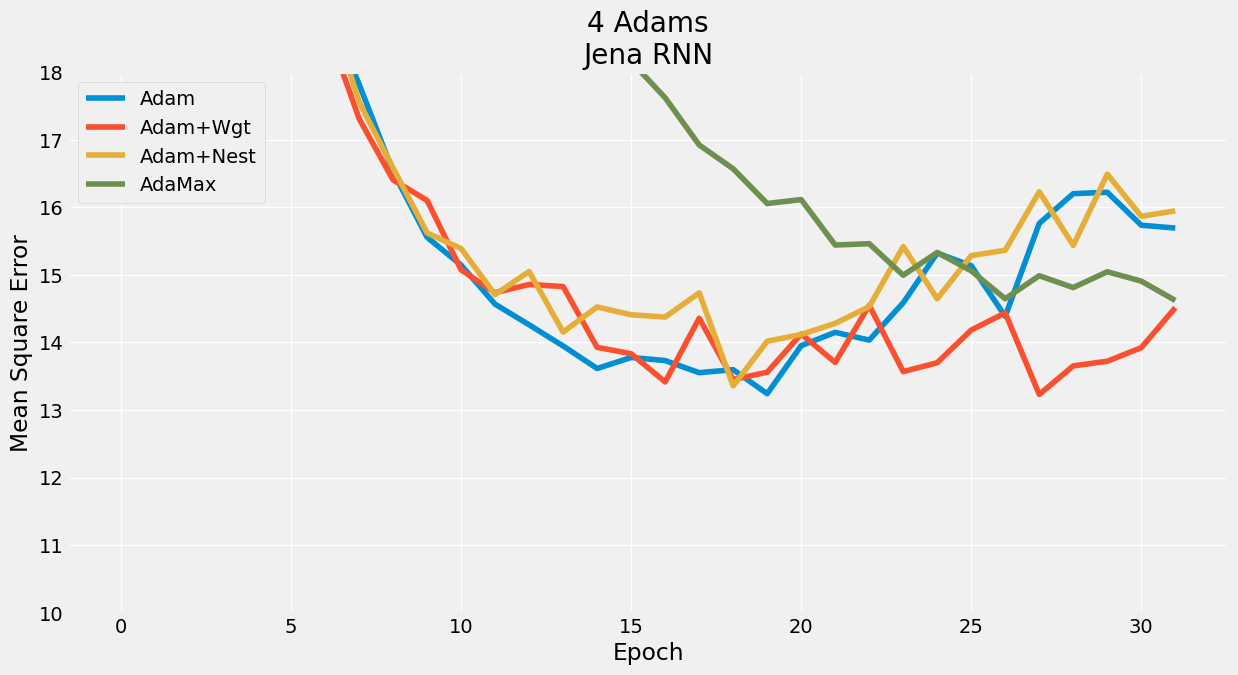

In [27]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams\nJena RNN')
plt.ylim([10,18])
plt.grid(color='white')
plt.show()

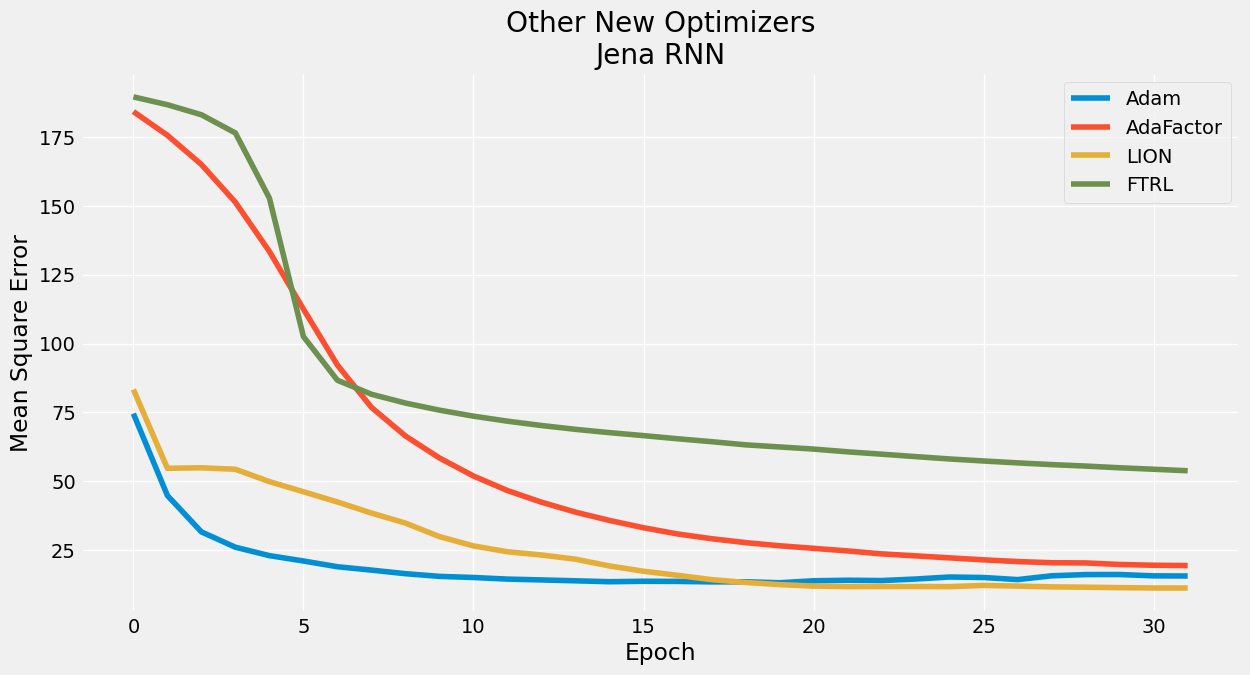

In [24]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers\nJena RNN')
plt.grid(color='white')
plt.show()

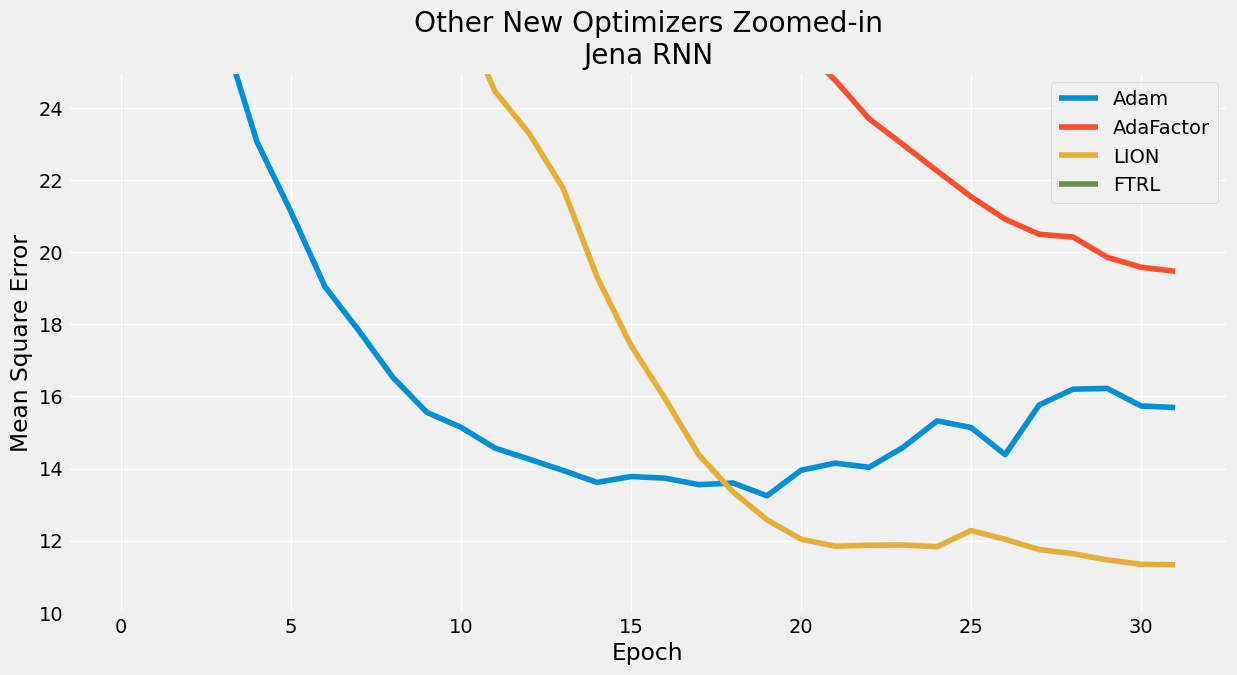

In [25]:
plt.figure(figsize=(13.33, 6.67))
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers Zoomed-in\nJena RNN')
plt.ylim([10,25])
plt.grid(color='white')
plt.show()

## Model Summary

In [26]:
m=model_core()
m.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,544 (76.35 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 23 (96.00 B)